# Using the `ncbi.datasets` python library to navigate NCBI assembly data

The `ncbi.datasets` python library can be used to query NCBI datasets and navigate through the results quickly within python. 

## Getting started

First, let's import the python modules we'll use.  Be sure you have first installed the requirements in 'requirements.txt' into your virtual environment.

In [1]:
import sys
import zipfile
import pandas as pd
from pprint import pprint
from datetime import datetime
from collections import defaultdict, Counter
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('ggplot')

try:
    import ncbi.datasets
except ImportError:
    print('ncbi.datasets module not found. To install, run `pip install ncbi-datasets-pylib`.')

## Assembly Descriptors

Assembly descriptions include all the meta-data you'll need, and can be accessed in three ways:
1. accession: an NCBI Assembly accession
2. organism: an organism or a taxonomical group name 
3. taxid: using an NCBI Taxonomy identifier, at any level.

First, we'll need an api object specific to retrieving assembly descriptors.  To see all the possible API instances, [visit the documentation on GitHub](https://github.com/ncbi/datasets/tree/master/client_docs/python#documentation-for-api-endpoints)

In [1]:
## start an api_instance 
api_instance = ncbi.datasets.AssemblyDatasetDescriptorsApi(ncbi.datasets.ApiClient())

### Assembly descriptions by accession

Let's start with the simplest case.  Say you already know the NCBI Assembly accession, for example, for the latest human reference genome assembly (GRCh38), `GCF_000001405.39`.  Using the `assembly_descriptor_by_accession()` method, we'll get back a `V1alpha1AssemblyDatasetDescriptors` object ([documented here](https://github.com/ncbi/datasets/blob/master/client_docs/python/docs/V1alpha1AssemblyDatasetDescriptors.md)). (a mouthful we know).  The various fields in the response are attributes of the object.

Let's see this in practice.

In [1]:
assembly_accession = 'GCF_000001405.39' ## needs to be a full accession.version

assembly_descriptor = api_instance.assembly_descriptors_by_accession(assembly_accession)

type(assembly_descriptor)


ncbi.datasets.models.v1alpha1_assembly_dataset_descriptors.V1alpha1AssemblyDatasetDescriptors

`assembly_descriptor` contains a description about the assembly and the total count of results in JSON format.

In [1]:
print(assembly_descriptor)

{'datasets': [{'annotation_metadata': {'file': [{'estimated_size': '49043324',
                                                 'type': 'GENOME_GFF'},
                                                {'estimated_size': '1314946692',
                                                 'type': 'GENOME_GBFF'},
                                                {'estimated_size': '117396760',
                                                 'type': 'RNA_FASTA'},
                                                {'estimated_size': '26197132',
                                                 'type': 'PROT_FASTA'}],
                                       'name': 'NCBI Annotation Release '
                                               '109.20200522',
                                       'release_date': 'May 22, 2020',
                                       'release_number': '109.20200522',
                                       'report_url': 'https://www.ncbi.nlm.nih.gov/genome/annotation_euk/Homo_s

In [1]:
print(f"Number of assemblies: {assembly_descriptor.total_count}" )

Number of assemblies: 1


In [1]:
## print other information 
for d in assembly_descriptor.datasets:
    print(d.assembly_accession, d.assembly_level, len(d.chromosomes), d.submission_date, sep = '\t')

GCF_000001405.39	Chromosome	26	2019-02-28


### Assembly descriptors by organism or tax group name 

Now let's say you only know the name of the organism for which you want to retrieve assembly information.

In [1]:
## a few examples to try 
# tax_name = 'mammals'
# tax_name = 'birds'
# tax_name = 'butterflies'
tax_name = 'primates'

assembly_descriptors = api_instance.assembly_descriptors_by_organism(
    tax_name = tax_name,
    limit = 'all')

In [1]:
print(f"Number of assemblies in the group '{tax_name}': {assembly_descriptors.total_count}")

Number of assemblies in the group 'primates': 243


#### Assemblies organized by GenBank/RefSeq
Now we can analyze the results and organize by GenBank and RefSeq, and make a nice tabular output and pie-chart of the results.

In [1]:
assm_counter = Counter()
for d in assembly_descriptors.datasets:
    if d.assembly_accession[:3] == 'GCA':
        assm_counter['GenBank'] += 1
    elif d.assembly_accession[:3] == 'GCF':
        assm_counter['RefSeq'] += 1
    
print(assm_counter)

Counter({'GenBank': 214, 'RefSeq': 29})


,count
RefSeq,29
GenBank,214


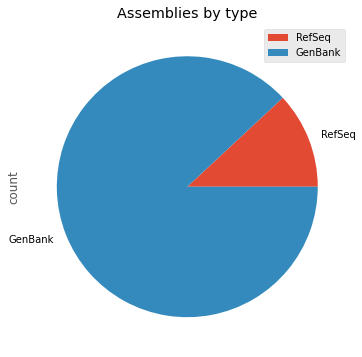

In [1]:
df = pd.DataFrame.from_dict(assm_counter, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by type')

#### Assemblies organized by assembly level
Alternatively, we can organize by the assembly level (scaffold, contig or choromosome).

In [1]:
assm_level = Counter()
for d in assembly_descriptors.datasets:
    assm_level[d.assembly_level] += 1
    
print(assm_level)

Counter({'Scaffold': 116, 'Chromosome': 64, 'Contig': 63})


,count
Scaffold,116
Chromosome,64
Contig,63


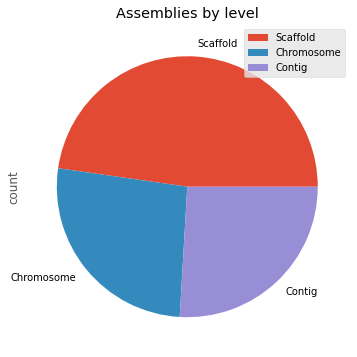

In [1]:
df = pd.DataFrame.from_dict(assm_level, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by level',)

#### Assemblies grouped and counted by annotation release number

All RefSeq assemblies are annotated and each annotation release is numbered, starting from 100. A quick way to check if the latest annotation is the first time an assembly for that organism was annotated is to check the annotation release number. Anything above 100 can be interpreted to have been through multiple annotations. 

For example, in the analysis shown below, the human assembly has an annotation release number 109 indicating that a human assembly was annotated multiple times. On the other hand, 'silvery gibbon' assembly has an annotation release number 100 indicating that this is the first time an assembly from this organism was annotated. 

In [1]:
## out of the 28 RefSeq assemblies, how many have been annotated more than once? 
annot_counter = Counter()
for d in assembly_descriptors.datasets:
    if d.assembly_accession.startswith('GCF') and d.annotation_metadata:
        rel = int(d.annotation_metadata.release_number.split('.')[0])
        annot_counter[rel] += 1
pprint(annot_counter)

Counter({100: 9, 101: 8, 103: 3, 102: 3, 104: 2, 105: 1, 109: 1})


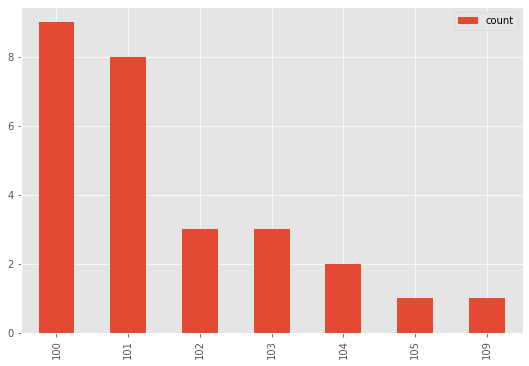

In [1]:
df = pd.DataFrame.from_dict(annot_counter, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(9,6))

#### Assemblies organized by annotation release number

In [1]:
annot_list = defaultdict(list)
for d in assembly_descriptors.datasets:
    if d.assembly_accession.startswith('GCF') and d.annotation_metadata:
        rel = d.annotation_metadata.release_number
        annot_list[rel].append(d.assembly_accession + ' ' + d.org.title)
pprint(annot_list)

defaultdict(<class 'list'>,
            {'100': ['GCF_000955945.1 sooty mangabey',
                     'GCF_000951045.1 drill',
                     'GCF_003255815.1 gelada',
                     'GCF_000951035.1 Colobus angolensis palliatus',
                     "GCF_009764315.1 Francois's langur",
                     'GCF_001698545.1 black snub-nosed monkey',
                     'GCF_001604975.1 Cebus capucinus imitator',
                     'GCF_009761245.1 Tufted capuchin',
                     "GCF_000956105.1 Coquerel's sifaka"],
             '101': ['GCF_009828535.2 silvery gibbon',
                     'GCF_000364345.1 crab-eating macaque',
                     'GCF_000956065.1 pig-tailed macaque',
                     'GCF_007565055.1 golden snub-nosed monkey',
                     "GCF_000952055.2 Ma's night monkey",
                     'GCF_000235385.1 Bolivian squirrel monkey',
                     'GCF_000164805.1 Philippine tarsier',
                     'GCF_000165

### Assembly descriptors by taxid
Finally, instead of a tax-name, you might have an organism tax-id.  Interestingly, like the tax-name, it can be at any level in the taxonomic tree.

In [1]:
# taxid = 8782 ## birds
# taxid = 7898 ## ray-finned fish
taxid = 37572 ## butterflies

assembly_descriptors = api_instance.assembly_descriptors_by_taxid(
    tax_id = taxid,
    limit = 'all',
    filters_refseq_only = True)

In [1]:
print(f"Number of assemblies: {assembly_descriptors.total_count}")

Number of assemblies: 8


In [1]:
## count number of GenBank and RefSeq assemblies
## all are RefSeq assemblies because 'filters_refseq_only=True' above
assm_counter = Counter()
for d in assembly_descriptors.datasets:
    assm_counter[d.assembly_accession[:3]] += 1
    
print(assm_counter)

Counter({'GCF': 8})


#### Group assemblies by annotation date

In [1]:
annot_rel_dates = Counter()
for d in assembly_descriptors.datasets:
    if not d.assembly_accession.startswith('GCF') or not d.annotation_metadata:
        continue
    rel_date = datetime.strptime(d.annotation_metadata.release_date, '%b %d, %Y')
    rel_year = datetime.strftime(rel_date, '%Y')
    annot_rel_dates[rel_year] += 1
pprint(sorted(annot_rel_dates.items()))

[('2015', 3), ('2017', 1), ('2018', 2), ('2020', 1)]


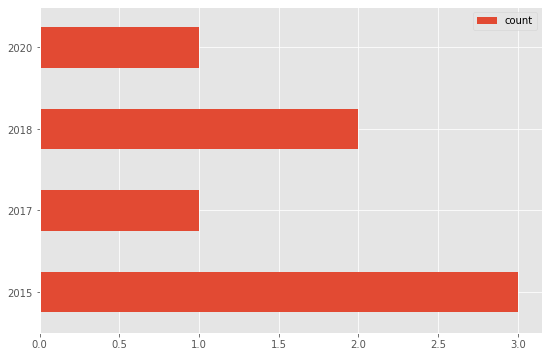

In [1]:
df = pd.DataFrame.from_dict(annot_rel_dates, orient='index', columns=['count']).sort_index()
df.plot(kind='barh', y='count', figsize=(9,6))

In [1]:
assm_table = {}
for d in assembly_descriptors.datasets:
    if not d.annotation_metadata:
        continue
    n_chr = len(d.chromosomes) if d.assembly_level == 'Chromosome' else None
    assm_table[d.assembly_accession] = {
        'assm_name': d.display_name,
        'annot_rel_date': d.annotation_metadata.release_date,
        'annot_rel_num': d.annotation_metadata.release_number,
        'assm_level': d.assembly_level,
        'num_chromosomes': n_chr,
        'contig_n50': d.contig_n50,
        'seq_length': d.seq_length,
        'submission_date': d.submission_date }
df = pd.DataFrame.from_dict(assm_table, orient='columns')
display(df)

,GCF_009731565.1,GCF_900239965.1,GCF_002938995.1,GCF_000836235.1,GCF_000836215.1,GCF_001298355.1,GCF_001856805.1
assm_name,Dplex_v4,Bicyclus_anynana_v1.2,ASM293899v1,Pxut_1.0,Ppol_1.0,Pap_ma_1.0,P_rapae_3842_assembly_v2
annot_rel_date,"Feb 24, 2020","Feb 16, 2018","Oct 03, 2018","Jul 31, 2015","Jul 30, 2015","Oct 28, 2015","Aug 08, 2017"
annot_rel_num,100,100,100,100,100,100,100
assm_level,Chromosome,Scaffold,Scaffold,Scaffold,Scaffold,Scaffold,Scaffold
num_chromosomes,31,None,None,None,None,None,None
contig_n50,108026,78697,254123,128246,47768,92238,54957
seq_length,248676414,475399557,357124929,243890167,227005758,278421261,245871251
submission_date,2019-12-11,2018-01-02,2018-02-23,2015-02-02,2015-02-02,2015-09-28,2016-10-16


## Genome assembly downloads
So far, we have looked at interacting with assembly descriptors, which describe the essential metadata for genome assemblies. But what if you want actual data for analysis. Using the Datasets API, you can download sequence data, annotation and a data report containing more detailed metadata for each assembly.

Using the above assembly descriptors, you can create a download request for a set of assemblies and chromosomes.  To illustrate, let's start by downloading a package with nucleotide sequence for mitochondria and all protein sequences for the latest human assembly.

In [1]:
download_api = ncbi.datasets.DownloadApi(ncbi.datasets.ApiClient())

In [1]:
assembly_accessions = ['GCF_000001405.39']
chromosomes = ['MT']
include_sequence = True
include_annotation_type = ['PROT_FASTA']

api_response = download_api.download_assembly_package(
    assembly_accessions,
    chromosomes=chromosomes,
    include_sequence=include_sequence,
    include_annotation_type=include_annotation_type,
    # Because we are streaming back the results to disk, 
    # we should defer reading/decoding the response
    _preload_content=False
)

with open('human_assembly.zip', 'wb') as f:
    f.write(api_response.data)


When we unpack the zip file, we see a BdBag structure.  Read more about the contents in the [download assembly command
 section of the documentation](https://www.ncbi.nlm.nih.gov/datasets/docs/command-line-assembly/).  In addition to metadata about the package, including md5 checksums, we see the data folder contains four files:
 1. The data report (`data_report.yaml`) for GCF_000001405.39.  It contains assembly information like sequence names,  NCBI accessions, UCSC-style chromosome names, and annotation statistics (gene counts)
 2. The nucleotide sequence in FASTA format for the one chromosome we requested: `chrMT.fna`
 3. All protein sequences in FASTA format: `protein.faa`
 4. And finally, a dataset catalog file (`dataset_catalog.json`) that describes the contents of the data, to aid in programmatic access.

In [1]:
!unzip -v human_assembly.zip

Archive:  human_assembly.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
      57  Defl:N       59  -4% 06-18-2020 20:21 b0865ddc  ncbi_dataset/bagit.txt
     998  Defl:N      627  37% 06-18-2020 20:21 44e1e93f  README.md
    1912  Defl:N     1266  34% 06-18-2020 20:21 366fd370  ncbi_dataset/data/GCF_000001405.39/data_report.yaml
   16834  Defl:N     5379  68% 06-18-2020 20:21 932c3ae8  ncbi_dataset/data/GCF_000001405.39/chrMT.fna
84837011  Defl:N 26197114  69% 06-18-2020 20:21 1c929b01  ncbi_dataset/data/GCF_000001405.39/protein.faa
     423  Defl:N      267  37% 06-18-2020 20:21 03e3fe80  ncbi_dataset/data/dataset_catalog.json
       0  Defl:N        2   0% 06-18-2020 20:21 00000000  ncbi_dataset/fetch.txt
     121  Defl:N      116   4% 06-18-2020 20:21 06e4d3d2  ncbi_dataset/bag-info.txt
     251  Defl:N      190  24% 06-18-2020 20:21 2ec53c79  ncbi_dataset/manifest-md5.txt
     190  Defl:N      142  2

## Combining Assembly descriptors and downloads

As discussed above, we can combine the assembly-descriptors API to retrieve a set of assembly accessions, and selectively download a data package. To demonstrate, we shall 

1. Fetch a list of RefSeq assembly accessions for all bird genomes using `assembly_descriptors_by_taxid` 
2. Filter assemblies that were annotated in 2019
3. Download data, but in this case, retrieve a dehydrated bag that can be later rehydrated when we are ready for the sequence data.

In [1]:
assembly_descriptors = api_instance.assembly_descriptors_by_taxid(
    tax_id=9989, ## Rodents taxid
    limit='all',
    filters_refseq_only=True)

print(f'Number of assemblies: {assembly_descriptors.total_count}')

Number of assemblies: 29


In [1]:
annots_by_year = Counter()
for d in assembly_descriptors.datasets:
    annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
    annots_by_year[annot_year] += 1
    
print(f'Assemblies grouped by year of annotation')
pprint(sorted(annots_by_year.items()))

Assemblies grouped by year of annotation
[(2015, 3), (2016, 4), (2017, 5), (2018, 6), (2019, 7), (2020, 4)]


In [1]:
rodents_annotated_in_2019_accs = []
for d in assembly_descriptors.datasets:
    annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
    if annot_year == 2019:
        rodents_annotated_in_2019_accs.append(d.assembly_accession)
        
print('Rodent assemblies that were annotated in 2019:')
print(f'{", ".join(rodents_annotated_in_2019_accs)}')

Rodent assemblies that were annotated in 2019:
GCF_004664715.1, GCF_004785775.1, GCF_900095145.1, GCF_000001635.26, GCF_900094665.1, GCF_008632895.1, GCF_000622305.1


In [1]:
assm_table = {}
for d in assembly_descriptors.datasets:
    annot_year = int(d.annotation_metadata.release_date.split(' ')[-1])
    if annot_year == 2019:
        n_chr = len(d.chromosomes) if d.assembly_level == 'Chromosome' else None
        assm_table[d.assembly_accession] = {
            'assm_name': d.display_name,
            'org_name': d.org.title,
            'sci_name': d.org.sci_name,
            'annot_rel_date': d.annotation_metadata.release_date,
            'annot_rel_num': d.annotation_metadata.release_number,
            'assm_level': d.assembly_level,
            'num_chromosomes': n_chr,
            'contig_n50': d.contig_n50,
            'seq_length': d.seq_length,
            'submission_date': d.submission_date }
df = pd.DataFrame.from_dict(assm_table, orient='columns')
display(df)

,GCF_004664715.1,GCF_004785775.1,GCF_900095145.1,GCF_000001635.26,GCF_900094665.1,GCF_008632895.1,GCF_000622305.1
assm_name,Pero_0.1,NIH_TR_1.0,PAHARI_EIJ_v1.1,GRCm38.p6,CAROLI_EIJ_v1.1,UCSF_Mcou_1,S.galili_v1.0
org_name,white-footed mouse,Grammomys surdaster,shrew mouse,house mouse,Ryukyu mouse,southern multimammate mouse,Upper Galilee mountains blind mole rat
sci_name,Peromyscus leucopus,Grammomys surdaster,Mus pahari,Mus musculus,Mus caroli,Mastomys coucha,Nannospalax galili
annot_rel_date,"Apr 18, 2019","Apr 18, 2019","Jun 14, 2019","Jul 12, 2019","Jun 07, 2019","Oct 18, 2019","Jun 05, 2019"
annot_rel_num,100,100,101,108,101,100,102
assm_level,Scaffold,Scaffold,Chromosome,Chromosome,Chromosome,Chromosome,Scaffold
num_chromosomes,None,None,25,23,22,4,None
contig_n50,4102727,51731,29465,32813180,30917,30483,30353
seq_length,2474055010,2412664998,2475012951,2730855475,2553112587,2507168619,3061408210
submission_date,2019-04-05,2019-04-12,2017-04-28,2017-09-15,2017-04-28,2019-09-24,2014-06-05


#### Download package for selected assemblies

For the assemblies collected above, download a dehydrated data package (hydrated=DATA_REPORT_ONLY).  This will only contain the data report, and defer collection of nucleotide and protein sequence data until rehydration.

In [1]:
%%time

print(f'Download a dehydrated package for {rodents_annotated_in_2019_accs}, with the ability to rehydrate with the CLI later on.')
dl_response = download_api.download_assembly_package(
    rodents_annotated_in_2019_accs,
    include_sequence=False,
    hydrated='DATA_REPORT_ONLY',
    _preload_content=False )

zipfile_name = 'rodent_genomes.zip'
with open(zipfile_name, 'wb') as f:
    f.write(dl_response.data)

print('Download complete')

Download a dehydrated package for ['GCF_004664715.1', 'GCF_004785775.1', 'GCF_900095145.1', 'GCF_000001635.26', 'GCF_900094665.1', 'GCF_008632895.1', 'GCF_000622305.1'], with the ability to rehydrate with the CLI later on.
Download complete
CPU times: user 186 ms, sys: 82.7 ms, total: 268 ms
Wall time: 9.54 s


In [1]:
!unzip -v {zipfile_name}

Archive:  rodent_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
      57  Defl:N       59  -4% 06-18-2020 20:30 b0865ddc  ncbi_dataset/bagit.txt
     998  Defl:N      627  37% 06-18-2020 20:30 44e1e93f  README.md
   17531  Defl:N    11286  36% 06-18-2020 20:30 130138ed  ncbi_dataset/data/GCF_000001635.26/data_report.yaml
31460871  Defl:N 19940055  37% 06-18-2020 20:30 f3d750ce  ncbi_dataset/data/GCF_000622305.1/data_report.yaml
  365280  Defl:N   232071  37% 06-18-2020 20:30 0ffcec1d  ncbi_dataset/data/GCF_004664715.1/data_report.yaml
 4832084  Defl:N  3056118  37% 06-18-2020 20:30 f32b8c64  ncbi_dataset/data/GCF_004785775.1/data_report.yaml
    7989  Defl:N     5185  35% 06-18-2020 20:30 fe541d7e  ncbi_dataset/data/GCF_008632895.1/data_report.yaml
  652020  Defl:N   416177  36% 06-18-2020 20:30 b18342ec  ncbi_dataset/data/GCF_900094665.1/data_report.yaml
  532338  Defl:N   340712  36% 06-18-2020

#### Rehydrate data package
To rehydrate, use the [NCBI Datasets command-line application](https://www.ncbi.nlm.nih.gov/datasets/docs/command-line-start/). For example, the following commands illustrate the process for Linux 
```
curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets'  
chmod +x datasets
./datasets rehydrate --filename rodent_genomes.zip
```
